In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix, component, n_component
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from bayesian.subsample import get_subsample
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc, LOO_validation
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import math
from pomegranate import DiscreteDistribution
import random
from sklearn.model_selection import train_test_split
from gmr import GMM
from gmr.utils import check_random_state
from gmr import MVN
from sklearn.datasets import make_spd_matrix
from sklearn.linear_model import LinearRegression
from sklearn.cluster import DBSCAN
from sklearn.covariance import EllipticEnvelope
from numpy import percentile
from scipy.stats import binned_statistic
from scipy.stats.distributions import chi2
import time
from scipy.stats.mstats import mquantiles

In [7]:
data = pd.read_csv('../data/daks_processed.csv')
#data = data.drop(columns=['Unnamed: 0'])
#columns = data.columns.tolist()
columns = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Hydrocarbon type', 'Depositional environment', 'Gross','Netpay','Porosity','Permeability', 'Depth']
data = data[columns]
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

In [5]:
data['Year'] = data['Year'].apply(lambda x: str(x))
data['Month'] = data['Month'].apply(lambda x: str(x))
data['Day'] = data['Day'].apply(lambda x: str(x))
data['Hour'] = data['Hour'].apply(lambda x: str(x))

In [6]:
def quantile2d(x,y,Nbins,nth):
    from numpy import percentile
    from scipy.stats import binned_statistic
    def myperc(x,n=nth):
        return(percentile(x,n))
    t=binned_statistic(x,y,statistic=myperc,bins=Nbins)
    return t

In [8]:
sample = data.loc[data['Tectonic regime'] == 'COMPRESSION']
sample.reset_index(inplace=True, drop=True)

In [10]:
Nbins=5
nth=95.
y = sample['Depth'].values
x = sample['Porosity'].values
t =quantile2d(y,x,Nbins,nth)
ii=[]
for i in range(Nbins):
    ii=ii+np.argwhere(((t.binnumber==i) & (x<t.statistic[i]))).flatten().tolist()
ii=np.array(ii,dtype=int)

In [11]:
new_data = sample.loc[ii, :]
new_data.reset_index(inplace=True, drop=True)

In [12]:
name1 = 'Porosity'
name2 = 'Depth'
n = int((component(new_data, [name1, name2], 'aic') + component(new_data, [name1, name2], 'bic'))/2)
n

4

In [13]:
colors = ["c", "m", "y", "g", "b", "r", '#d62728', "w", '#1f77b4', '#17becf']
c = random.sample(colors, n)

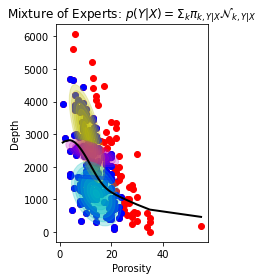

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from gmr.utils import check_random_state
from gmr import MVN, GMM, plot_error_ellipses


random_state = check_random_state(0)

n_samples = new_data.shape[0]
X = new_data[[name1, name2]].values


X_test = np.array(sorted(sample[name1].values))
X_point = sample[[name1, name2]].values

gmm = GMM(n_components=n, random_state=0)
gmm.from_samples(X)
Y = gmm.predict(np.array([0]), X_test[:, np.newaxis])

plt.subplot(1, 2, 2)
plt.title("Mixture of Experts: $p(Y | X) = \Sigma_k \pi_{k, Y|X} "
          "\mathcal{N}_{k, Y|X}$")
plt.scatter(X_point[:, 0], X_point[:, 1], c=['r'])
plt.scatter(X_point[ii, 0], X_point[ii, 1], c=['b'])
plt.xlabel(name1)
plt.ylabel(name2)
plot_error_ellipses(plt.gca(), gmm, colors=c)
plt.plot(X_test, Y.ravel(), c="k", lw=2)

plt.show()

In [15]:
sample2 = copy(data)

In [16]:
name1 = 'Porosity'
name2 = 'Depth'
n = int((component(sample2, [name1, name2], 'aic') + component(sample2, [name1, name2], 'bic'))/2)
n

2

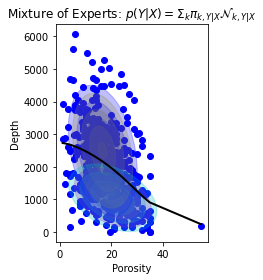

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from gmr.utils import check_random_state
from gmr import MVN, GMM, plot_error_ellipses


random_state = check_random_state(0)

n_samples = sample2.shape[0]
X = sample2[[name1, name2]].values


X_test = np.array(sorted(sample2[name1].values))
X_point = sample2[[name1, name2]].values

gmm = GMM(n_components=n, random_state=0)
gmm.from_samples(X)
Y = gmm.predict(np.array([0]), X_test[:, np.newaxis])

plt.subplot(1, 2, 2)
plt.title("Mixture of Experts: $p(Y | X) = \Sigma_k \pi_{k, Y|X} "
          "\mathcal{N}_{k, Y|X}$")
plt.scatter(X_point[:, 0], X_point[:, 1], c=['b'])
plt.xlabel(name1)
plt.ylabel(name2)
plot_error_ellipses(plt.gca(), gmm, colors=c)
plt.plot(X_test, Y.ravel(), c="k", lw=2)

plt.show()

## Байесовские сети с доп. дискретными узлами

In [18]:
data = pd.read_csv('../data/daks_processed.csv')
#data = data.drop(columns=['Unnamed: 0'])
#columns = data.columns.tolist()
columns = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Hydrocarbon type', 'Depositional environment', 'Gross','Netpay','Porosity','Permeability', 'Depth']
data = data[columns]
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

In [19]:
node_types = get_nodes_type(data)
columns_for_disc = []
columns_for_code = []
for key in node_types.keys():
    if node_types[key] == 'cont':
        columns_for_disc.append(key)
    else:
        columns_for_code.append(key)

In [20]:
code_data, coder = code_categories(data, 'label', columns_for_code)
discrete_data, coder = discretization(code_data, 'equal_frequency', columns_for_disc)

In [21]:
bn_full = structure_learning(discrete_data, 'HC', node_types, 'K2')

In [22]:
droped_edges = []
new_edges = []
nodes = []
for c in columns_for_disc:
    flag = False
    for edge in bn_full['E']:
        new_edge = []
        if (edge[1] == c) & (node_types[edge[0]] == 'disc'):
            new_edge.append(edge[0])
            new_edge.append(c + ' disc')
            new_edges.append(new_edge)
            droped_edges.append(edge)
            flag = True
    if flag == True:     
        new_edges.append([c + ' disc', c])
        bn_full['V'].append(c + ' disc')
        nodes.append(c)

In [23]:
bn_full['E'] = [l for l in bn_full['E'] if l not in droped_edges]
bn_full['E'] = bn_full['E'] + new_edges

In [24]:
for c in nodes:
    discrete_data[c] = discrete_data[c].apply(lambda x: str(x))
    data[c + ' disc'] = discrete_data[c]

In [25]:
bn_full

{'V': ['Tectonic regime',
  'Period',
  'Lithology',
  'Structural setting',
  'Hydrocarbon type',
  'Depositional environment',
  'Gross',
  'Netpay',
  'Porosity',
  'Permeability',
  'Depth',
  'Gross disc',
  'Porosity disc',
  'Permeability disc',
  'Depth disc'],
 'E': [['Tectonic regime', 'Structural setting'],
  ['Lithology', 'Depositional environment'],
  ['Structural setting', 'Period'],
  ['Gross', 'Netpay'],
  ['Porosity', 'Permeability'],
  ['Porosity', 'Depth'],
  ['Structural setting', 'Gross disc'],
  ['Depositional environment', 'Gross disc'],
  ['Gross disc', 'Gross'],
  ['Period', 'Porosity disc'],
  ['Porosity disc', 'Porosity'],
  ['Lithology', 'Permeability disc'],
  ['Permeability disc', 'Permeability'],
  ['Tectonic regime', 'Depth disc'],
  ['Depth disc', 'Depth']]}

In [26]:
for c in columns_for_disc:
    node_types[c + ' disc'] = 'disc'

In [27]:
draw_BN(bn_full, node_types, 'new_geo')

In [28]:
params = parameter_learning(data, node_types, bn_full, 'mix')
save_structure(bn_full, 'all_net')
skel = read_structure('all_net')
save_params(params, 'all_net_param')
params = read_params('all_net_param')
all_bn = HyBayesianNetwork(skel, params)